<a href="https://colab.research.google.com/github/mehmetdamkaci/pneumoniaDetect/blob/main/pn%C3%B6moniDetect_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Pre-Processing

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
from tqdm import tqdm
import cv2
import numpy as np
import random

def dataRead(mainPath):

    data = []
    label = []

    for folder in os.listdir(mainPath):

        dataPath = os.path.join(mainPath, folder)

        if os.path.isdir(dataPath):

            for dataFile in tqdm(os.listdir(dataPath), desc='DATA READİNG'):

                filePath = os.path.join(dataPath, dataFile)

                if os.path.isfile(filePath):

                    image = cv2.imread(filePath)
                    grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    resizeImage = cv2.resize(grayImage, (64,64))
                    normalizedImage = resizeImage/255.0
                    flattenImg = normalizedImage.flatten()

                    if folder=='NORMAL':
                        label.append(0)
                    else:
                        label.append(1)

                    data.append(flattenImg)

    return np.array(data), np.array(label) 

In [ ]:
mainPath = '/content/gdrive/My Drive/ANN Project/ChestXray/'
metaData, metaLabel = dataRead(mainPath=mainPath)

DATA READİNG: 100%|██████████| 1709/1709 [00:29<00:00, 58.47it/s]


In [ ]:
print(f'Number Of NORMAL Data : {(metaLabel==0).sum()}')
print(f'Number Of PNEUMONIA Data: {(metaLabel==1).sum()}')

Number Of NORMAL Data : 1583
Number Of PNEUMONIA Data: 1709


In [ ]:
from sklearn.model_selection import train_test_split

trainData, testData, trainLabel, testLabel = train_test_split(metaData, metaLabel ,random_state=104, train_size=0.8, shuffle=True)

print(f'Shape Of trainData : {trainData.shape}')
print(f'Shape Of testData : {testData.shape}')

Shape Of trainData : (2633, 4096)
Shape Of testData : (659, 4096)


In [ ]:
np.save('/content/gdrive/My Drive/ANN Project/trainData_DNN.npy', trainData)
np.save('/content/gdrive/My Drive/ANN Project/trainLabel_DNN.npy', trainLabel)
np.save('/content/gdrive/My Drive/ANN Project/testData_DNN.npy', testData)
np.save('/content/gdrive/My Drive/ANN Project/testLabel_DNN.npy', testLabel)

#Tek Gizli Katmanlı Model

In [ ]:
trainData = np.load('/content/gdrive/My Drive/ANN Project/trainData_DNN.npy')
trainLabel = np.load('/content/gdrive/My Drive/ANN Project/trainLabel_DNN.npy')
testData = np.load('/content/gdrive/My Drive/ANN Project/testData_DNN.npy')
testLabel = np.load('/content/gdrive/My Drive/ANN Project/testLabel_DNN.npy')

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

def buildModel(inputVector):

    layer1 = Dense(128, activation='relu')(inputVector)  
    layer2 = Dense(1, activation='sigmoid')(layer1)

    return layer2

length=4096
inputSignal = Input(shape=(length,))
model=Model(inputs=inputSignal, outputs=buildModel(inputSignal))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 4096)]            0         
                                                                 
 dense_39 (Dense)            (None, 128)               524416    
                                                                 
 dense_40 (Dense)            (None, 1)                 129       
                                                                 
Total params: 524,545
Trainable params: 524,545
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import ModelCheckpoint

filepath='/content/gdrive/MyDrive/ANN Project/Models/DNN_one_hidden_bestModel.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',verbose=2, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
    
batch_size=64
epochs=50

hist=model.fit( trainData,
                trainLabel,
                epochs=epochs,
                shuffle=True,
                batch_size=batch_size,
                verbose=2,
                validation_split=0.15,
                callbacks=callbacks_list)

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.80759, saving model to /content/gdrive/MyDrive/ANN Project/Models/DNN_one_hidden_bestModel.h5
35/35 - 2s - loss: 0.9609 - accuracy: 0.5715 - val_loss: 0.6040 - val_accuracy: 0.8076 - 2s/epoch - 43ms/step
Epoch 2/50

Epoch 2: val_accuracy improved from 0.80759 to 0.86835, saving model to /content/gdrive/MyDrive/ANN Project/Models/DNN_one_hidden_bestModel.h5
35/35 - 0s - loss: 0.5368 - accuracy: 0.8365 - val_loss: 0.4656 - val_accuracy: 0.8684 - 392ms/epoch - 11ms/step
Epoch 3/50

Epoch 3: val_accuracy improved from 0.86835 to 0.88354, saving model to /content/gdrive/MyDrive/ANN Project/Models/DNN_one_hidden_bestModel.h5
35/35 - 0s - loss: 0.4164 - accuracy: 0.8588 - val_loss: 0.3643 - val_accuracy: 0.8835 - 439ms/epoch - 13ms/step
Epoch 4/50

Epoch 4: val_accuracy improved from 0.88354 to 0.90127, saving model to /content/gdrive/MyDrive/ANN Project/Models/DNN_one_hidden_bestModel.h5
35/35 - 0s - loss: 0.3439 - accuracy: 0.8713 - 

In [ ]:
filepath='/content/gdrive/MyDrive/ANN Project/Models/DNN_one_hidden_bestModel.h5'
predModel=Model(inputs=inputSignal, outputs=buildModel(inputSignal))
predModel.load_weights(filepath)
predModel.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

test_dataset = tf.data.Dataset.from_tensor_slices((testData, testLabel))
test_dataset = test_dataset.batch(64)
result = predModel.evaluate(test_dataset)

11/11 [==============================] - 0s 5ms/step - loss: 0.1684 - accuracy: 0.9408


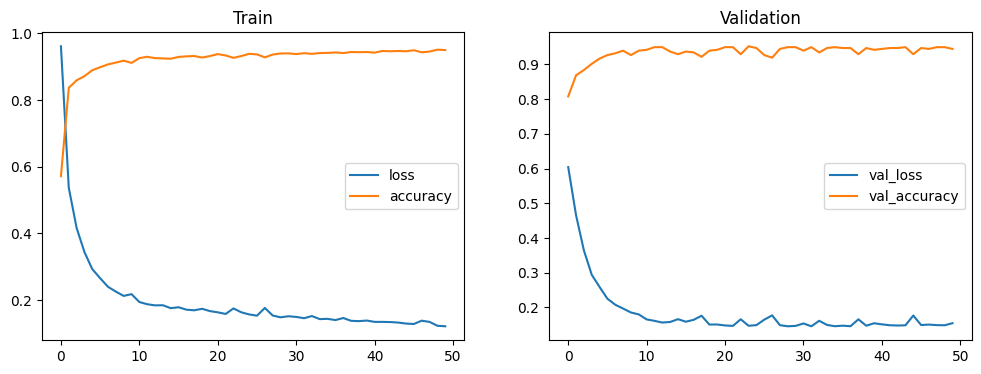

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['accuracy'])
plt.title('Train')
plt.legend(['loss', 'accuracy'])

plt.subplot(1,2,2)
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['val_accuracy'])
plt.title('Validation')
plt.legend(['val_loss', 'val_accuracy'])
plt.show()

#Model ve Eğitim Yorumları
* Bu mimaride sadece Dense katmanları kullanacağız. Modeli incelediğimizde, model sadece 1 gizli katmandan ve bir çıkış katmanından oluşmaktadır. Gizli katmanda 128 tane nöron bulunmaktadır ve aktivasyon fonksiyonu ise relu seçilmiştir.
* Eğitim incelendiğinde modelde herhangi bir ezberleme durumu gözlemlenmemiştir. Epoch sayısı artırılırsa bu durum belki değişebilir. Fakat 50 epoch boyunca model ezberlememiştir. Validation accuracy ve loss incelendiğinde de bunu anlayabiliyoruz.
* Test verisi üzerinde %94.08 başarı elde ederek model öğrenmiştir.

#Optimize
* Modelin şu an test verisi üzerinde olan başarı iyidir bu yüzden yapacağımız optimizeler sonucu başarı çok fazla değişmeyecektir.

#Daha Derin Bir Model

* Modeli derinleştirmenin sonucunda model daha fazla feature öğrenecektir. Bu durumda ezberleme olasılığı da mevcuttur bu yüzden Dropout katmanları da kullanmamız gerekiyor.

In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout

def buildModel(inputVector):

    layer1 = Dense(128, activation='relu')(inputVector)
    layer2 = Dense(128, activation='relu')(layer1)    
    layer3 = Dropout(0.25)(layer2)  
    layer4 = Dense(64, activation='relu')(layer3)  
    layer5 = Dense(64, activation='relu')(layer4)
    layer6 = Dropout(0.25)(layer5)
    layer7 = Dense(32, activation='relu')(layer6)  
    layer8 = Dense(32, activation='relu')(layer7)  
    layer9 = Dropout(0.25)(layer8)
    layer10 = Dense(16, activation='relu')(layer9)      
    layer11 = Dense(1, activation='sigmoid')(layer10)

    return layer11

length=4096
inputSignal = Input(shape=(length,))
model=Model(inputs=inputSignal, outputs=buildModel(inputSignal))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 4096)]            0         
                                                                 
 dense_41 (Dense)            (None, 128)               524416    
                                                                 
 dense_42 (Dense)            (None, 128)               16512     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_43 (Dense)            (None, 64)                8256      
                                                                 
 dense_44 (Dense)            (None, 64)                4160      
                                                                 
 dropout_12 (Dropout)        (None, 64)                0  

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath='/content/gdrive/MyDrive/ANN Project/Models/DNN_optimize_bestModel.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',verbose=2, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
    
batch_size=64
epochs=50

hist=model.fit( trainData,
                trainLabel,
                epochs=epochs,
                shuffle=True,
                batch_size=batch_size,
                verbose=2,
                validation_split=0.15,
                callbacks=callbacks_list)

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.49367, saving model to /content/gdrive/MyDrive/ANN Project/Models/DNN_optimize_bestModel.h5
35/35 - 2s - loss: 0.7019 - accuracy: 0.5241 - val_loss: 0.6841 - val_accuracy: 0.4937 - 2s/epoch - 69ms/step
Epoch 2/50

Epoch 2: val_accuracy improved from 0.49367 to 0.85316, saving model to /content/gdrive/MyDrive/ANN Project/Models/DNN_optimize_bestModel.h5
35/35 - 1s - loss: 0.6010 - accuracy: 0.6761 - val_loss: 0.3656 - val_accuracy: 0.8532 - 564ms/epoch - 16ms/step
Epoch 3/50

Epoch 3: val_accuracy improved from 0.85316 to 0.87342, saving model to /content/gdrive/MyDrive/ANN Project/Models/DNN_optimize_bestModel.h5
35/35 - 0s - loss: 0.3645 - accuracy: 0.8588 - val_loss: 0.3207 - val_accuracy: 0.8734 - 486ms/epoch - 14ms/step
Epoch 4/50

Epoch 4: val_accuracy improved from 0.87342 to 0.93418, saving model to /content/gdrive/MyDrive/ANN Project/Models/DNN_optimize_bestModel.h5
35/35 - 1s - loss: 0.2612 - accuracy: 0.8990 - val_loss

In [ ]:
filepath='/content/gdrive/MyDrive/ANN Project/Models/DNN_optimize_bestModel.h5'
predModel=Model(inputs=inputSignal, outputs=buildModel(inputSignal))
predModel.load_weights(filepath)
predModel.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

test_dataset = tf.data.Dataset.from_tensor_slices((testData, testLabel))
test_dataset = test_dataset.batch(64)
result = predModel.evaluate(test_dataset)

11/11 [==============================] - 1s 6ms/step - loss: 0.1679 - accuracy: 0.9439


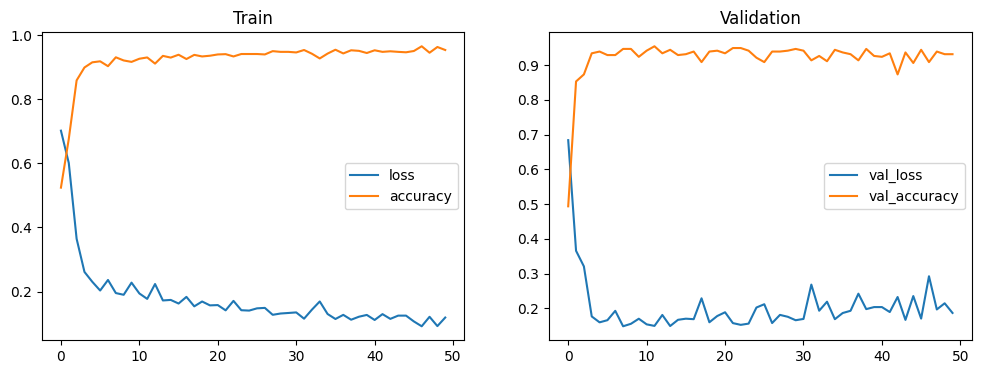

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['accuracy'])
plt.title('Train')
plt.legend(['loss', 'accuracy'])

plt.subplot(1,2,2)
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['val_accuracy'])
plt.title('Validation')
plt.legend(['val_loss', 'val_accuracy'])
plt.show()

Yorum

* Modelin derinleşmesine rağmen modelin test verisi üzerindeki başarısı çok az iyileşmiştir. Başarının bu şekilde olmasının büyük bir sebebi verinin ön işlemesinden kaynaklanmaktadır. Veriye resize işlemi uygulandığı için ve daha sonra tek boyuta düşürüldüğünde verinin bir kısmı kaybedilir. İşlem gücümüz donanımsal olarak kısıtlı olduğu üçün verilerde boyut düşürme işlemine başvurulmuştur.

#Modelin Parametre Sayısını Artırmak
* Herbir katmandaki nöron sayısı iki katına çıkarılmıştır. Bu sayede parametre sayısı artmıştır. Modelin iyi bir başarı göstermesi beklenebilir.

In [ ]:
def buildModel(inputVector):

    layer1 = Dense(128*2, activation='relu')(inputVector)
    layer2 = Dense(128*2, activation='relu')(layer1)    
    layer3 = Dropout(0.25)(layer2)  
    layer4 = Dense(64*2, activation='relu')(layer3)  
    layer5 = Dense(64*2, activation='relu')(layer4)
    layer6 = Dropout(0.25)(layer5)
    layer7 = Dense(32*2, activation='relu')(layer6)  
    layer8 = Dense(32*2, activation='relu')(layer7)  
    layer9 = Dropout(0.25)(layer8)
    layer10 = Dense(16*2, activation='relu')(layer9)      
    layer11 = Dense(1, activation='sigmoid')(layer10)

    return layer11

length=4096
inputSignal = Input(shape=(length,))
model=Model(inputs=inputSignal, outputs=buildModel(inputSignal))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 4096)]            0         
                                                                 
 dense_73 (Dense)            (None, 256)               1048832   
                                                                 
 dense_74 (Dense)            (None, 256)               65792     
                                                                 
 dropout_23 (Dropout)        (None, 256)               0         
                                                                 
 dense_75 (Dense)            (None, 128)               32896     
                                                                 
 dense_76 (Dense)            (None, 128)               16512     
                                                                 
 dropout_24 (Dropout)        (None, 128)               0  

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath='/content/gdrive/MyDrive/ANN Project/Models/DNN_optimize_parameter_bestModel.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',verbose=2, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
    
batch_size=64
epochs=50

hist=model.fit( trainData,
                trainLabel,
                epochs=epochs,
                shuffle=True,
                batch_size=batch_size,
                verbose=2,
                validation_split=0.15,
                callbacks=callbacks_list)

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.71646, saving model to /content/gdrive/MyDrive/ANN Project/Models/DNN_optimize_parameter_bestModel.h5
35/35 - 5s - loss: 0.6248 - accuracy: 0.6390 - val_loss: 0.5651 - val_accuracy: 0.7165 - 5s/epoch - 129ms/step
Epoch 2/50

Epoch 2: val_accuracy improved from 0.71646 to 0.91392, saving model to /content/gdrive/MyDrive/ANN Project/Models/DNN_optimize_parameter_bestModel.h5
35/35 - 1s - loss: 0.4009 - accuracy: 0.8275 - val_loss: 0.2363 - val_accuracy: 0.9139 - 852ms/epoch - 24ms/step
Epoch 3/50

Epoch 3: val_accuracy improved from 0.91392 to 0.92658, saving model to /content/gdrive/MyDrive/ANN Project/Models/DNN_optimize_parameter_bestModel.h5
35/35 - 1s - loss: 0.2750 - accuracy: 0.8829 - val_loss: 0.2067 - val_accuracy: 0.9266 - 838ms/epoch - 24ms/step
Epoch 4/50

Epoch 4: val_accuracy improved from 0.92658 to 0.93924, saving model to /content/gdrive/MyDrive/ANN Project/Models/DNN_optimize_parameter_bestModel.h5
35/35 - 1s - l

In [ ]:
filepath='/content/gdrive/MyDrive/ANN Project/Models/DNN_optimize_parameter_bestModel.h5'
predModel=Model(inputs=inputSignal, outputs=buildModel(inputSignal))
predModel.load_weights(filepath)
predModel.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

test_dataset = tf.data.Dataset.from_tensor_slices((testData, testLabel))
test_dataset = test_dataset.batch(64)
result = predModel.evaluate(test_dataset)

11/11 [==============================] - 1s 16ms/step - loss: 0.1697 - accuracy: 0.9469


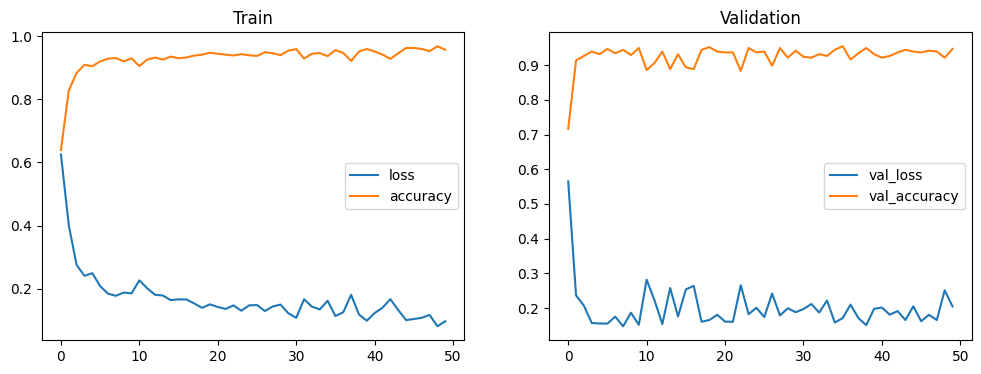

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['accuracy'])
plt.title('Train')
plt.legend(['loss', 'accuracy'])

plt.subplot(1,2,2)
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['val_accuracy'])
plt.title('Validation')
plt.legend(['val_loss', 'val_accuracy'])
plt.show()

Yorum
* Modelin parametre sayısının artırılmasıyla sonucun çok az daha iyi çıktığı gözlemlenmiştir. Bu beklenen bir durumdur.

#Veri Boyutunu Artırmak
* Giriş veri boyutunu 4 katına çıkararak en optimize modelde testler yapılacaktır. Veri boyutu arttığı için modelin test verisi üzerinde daha iyi bir başarı göstermesi beklenmektedir.

In [ ]:
import os
from tqdm import tqdm
import cv2
import numpy as np
import random
from sklearn.model_selection import train_test_split

def dataRead(mainPath):

    data = []
    label = []

    for folder in os.listdir(mainPath):

        dataPath = os.path.join(mainPath, folder)

        if os.path.isdir(dataPath):

            for dataFile in tqdm(os.listdir(dataPath), desc='DATA READİNG'):

                filePath = os.path.join(dataPath, dataFile)

                if os.path.isfile(filePath):

                    image = cv2.imread(filePath)
                    grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    resizeImage = cv2.resize(grayImage, (128,128))
                    normalizedImage = resizeImage/255.0
                    flattenImg = normalizedImage.flatten()

                    if folder=='NORMAL':
                        label.append(0)
                    else:
                        label.append(1)

                    data.append(flattenImg)

    return np.array(data), np.array(label) 

mainPath = '/content/gdrive/My Drive/ANN Project/ChestXray/'
metaData, metaLabel = dataRead(mainPath=mainPath)

trainData, testData, trainLabel, testLabel = train_test_split(metaData, metaLabel ,random_state=104, train_size=0.8, shuffle=True)

print(f'Shape Of trainData : {trainData.shape}')
print(f'Shape Of testData : {testData.shape}')

DATA READİNG: 100%|██████████| 1709/1709 [00:28<00:00, 59.40it/s]


Shape Of trainData : (2633, 16384)
Shape Of testData : (659, 16384)


In [ ]:
def buildModel(inputVector):

    layer1 = Dense(128*2, activation='relu')(inputVector)
    layer2 = Dense(128*2, activation='relu')(layer1)    
    layer3 = Dropout(0.25)(layer2)  
    layer4 = Dense(64*2, activation='relu')(layer3)  
    layer5 = Dense(64*2, activation='relu')(layer4)
    layer6 = Dropout(0.25)(layer5)
    layer7 = Dense(32*2, activation='relu')(layer6)  
    layer8 = Dense(32*2, activation='relu')(layer7)  
    layer9 = Dropout(0.25)(layer8)
    layer10 = Dense(16*2, activation='relu')(layer9)      
    layer11 = Dense(1, activation='sigmoid')(layer10)

    return layer11

length=16384
inputSignal = Input(shape=(length,))
model=Model(inputs=inputSignal, outputs=buildModel(inputSignal))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 16384)]           0         
                                                                 
 dense_97 (Dense)            (None, 256)               4194560   
                                                                 
 dense_98 (Dense)            (None, 256)               65792     
                                                                 
 dropout_32 (Dropout)        (None, 256)               0         
                                                                 
 dense_99 (Dense)            (None, 128)               32896     
                                                                 
 dense_100 (Dense)           (None, 128)               16512     
                                                                 
 dropout_33 (Dropout)        (None, 128)               0  

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath='/content/gdrive/MyDrive/ANN Project/Models/DNN_optimize_dimplus_bestModel.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',verbose=2, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
    
batch_size=64
epochs=50

hist=model.fit( trainData,
                trainLabel,
                epochs=epochs,
                shuffle=True,
                batch_size=batch_size,
                verbose=2,
                validation_split=0.15,
                callbacks=callbacks_list)

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.49367, saving model to /content/gdrive/MyDrive/ANN Project/Models/DNN_optimize_dimplus_bestModel.h5
35/35 - 4s - loss: 0.7791 - accuracy: 0.4942 - val_loss: 0.6963 - val_accuracy: 0.4937 - 4s/epoch - 128ms/step
Epoch 2/50

Epoch 2: val_accuracy improved from 0.49367 to 0.80000, saving model to /content/gdrive/MyDrive/ANN Project/Models/DNN_optimize_dimplus_bestModel.h5
35/35 - 3s - loss: 0.7113 - accuracy: 0.5179 - val_loss: 0.6575 - val_accuracy: 0.8000 - 3s/epoch - 72ms/step
Epoch 3/50

Epoch 3: val_accuracy improved from 0.80000 to 0.84810, saving model to /content/gdrive/MyDrive/ANN Project/Models/DNN_optimize_dimplus_bestModel.h5
35/35 - 3s - loss: 0.6274 - accuracy: 0.6443 - val_loss: 0.3799 - val_accuracy: 0.8481 - 3s/epoch - 97ms/step
Epoch 4/50

Epoch 4: val_accuracy improved from 0.84810 to 0.90886, saving model to /content/gdrive/MyDrive/ANN Project/Models/DNN_optimize_dimplus_bestModel.h5
35/35 - 3s - loss: 0.4336 - 

In [ ]:
filepath='/content/gdrive/MyDrive/ANN Project/Models/DNN_optimize_dimplus_bestModel.h5'
predModel=Model(inputs=inputSignal, outputs=buildModel(inputSignal))
predModel.load_weights(filepath)
predModel.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

test_dataset = tf.data.Dataset.from_tensor_slices((testData, testLabel))
test_dataset = test_dataset.batch(64)
result = predModel.evaluate(test_dataset)

11/11 [==============================] - 1s 20ms/step - loss: 0.1573 - accuracy: 0.9530


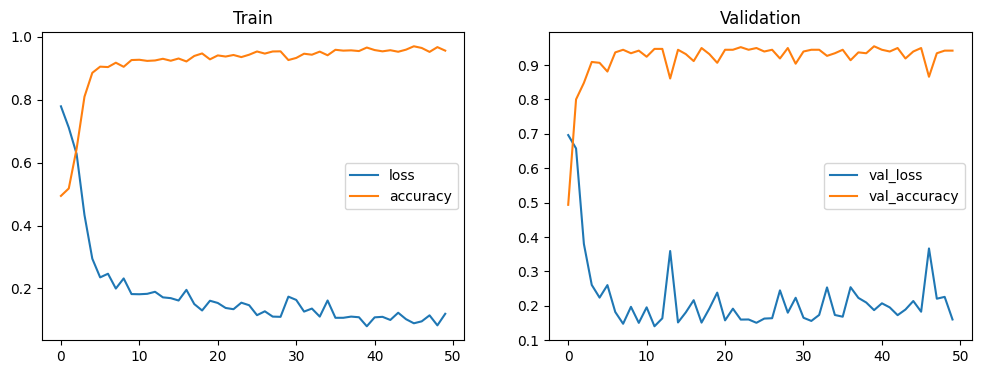

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['accuracy'])
plt.title('Train')
plt.legend(['loss', 'accuracy'])

plt.subplot(1,2,2)
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['val_accuracy'])
plt.title('Validation')
plt.legend(['val_loss', 'val_accuracy'])
plt.show()

Yorum ve Sonuç
* Giriş boyutu 4 katına çıkarıldığında modelin test verisi üzerindeki başarısı %94.69'dan %95.30'a çıkmıştır. Bu beklenen bir durumdur. Daha büyük bir boyutta veri olduğunda model daha fazla öğrenecektir. 
* Sonuç olarak modeli derinleştirmenin ve parametre sayısını artırmanın başarıyı veri boyutunu artırmadan daha az etkilediğini gözlemledik. Bu da bize modeli optimize etmek çok önemli fakat optimize edilen modele girdi olarak verilen verinin de çok önemli olduğu söylüyor.